In [79]:
import numpy as np
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout2D, RepeatVector
from keras.callbacks import EarlyStopping
from keras import metrics
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns

In [2]:
# data loading
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,Vy,Vx,theta,psi,phi,omega_Xv,omega_Yv,alpha_Xv,alpha_Yv,y_norm,x_norm,theta_norm,Vx_norm,Vy_norm,lane,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.03,5.06,237.273,0.538,-1.124,0.26,-0.65,0.114,0.264,0.786530,0.206384,0.659098,0.778120,0.764706,0,0.795350,0.203490
43617,42.246167,-83.563112,0.03,5.02,237.211,0.546,-1.151,-0.30,-0.95,-0.011,0.052,0.785304,0.204631,0.658926,0.771957,0.764706,0,0.787305,0.203073
43667,42.246155,-83.563137,0.03,4.97,237.141,0.579,-1.066,0.35,0.15,-0.034,0.155,0.784089,0.202890,0.658731,0.764253,0.764706,0,0.788982,0.203170
43717,42.246143,-83.563163,0.03,4.93,237.076,0.566,-0.967,0.66,-0.29,-0.037,0.253,0.782877,0.201164,0.658551,0.758089,0.764706,0,0.794082,0.195338
43767,42.246131,-83.563188,0.02,4.90,236.990,0.515,-0.921,-0.25,0.01,0.162,0.064,0.781676,0.199454,0.658312,0.753467,0.705882,0,0.791014,0.203958


In [3]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)

In [4]:
# calculating max_y_len and max_x_len

max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

embedding_dim = 128
latent_dim = 300

max_x_len, max_y_len

(77, 3822)

## model design: LSTM autoencoder

In [18]:
x_input = Input(shape=(77,5,))

# dense layer of spatial embedding
x_embedd1 = Dense(256)
x_embedd2 = Dense(embedding_dim)
x_h_st = x_embedd1(x_embedd2(x_input))

# encoder
encoder_l1 = LSTM(embedding_dim, return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(x_h_st)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = LSTM(embedding_dim, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

# decoder
decoder_inputs = RepeatVector(77)(encoder_outputs2[0])
decoder_l1 = LSTM(embedding_dim, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_l2 = LSTM(embedding_dim, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(Dense(2))(decoder_l2)

model_e2d2 = Model(inputs=x_input, outputs=decoder_outputs2)
model_e2d2.compile(
    loss='mean_squared_error', optimizer='adam', 
    metrics=[metrics.mean_absolute_percentage_error]
    )

In [6]:
# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll)
x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
# y_train = np.asarray(y_ll)
y_train = np.asarray(y_gps_ll)

# reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
mc = keras.callbacks.ModelCheckpoint(
    '../models/autoencode_v2', monitor='mean_absolute_percentage_error', save_weights_only=True,
    mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

history = model_e2d2.fit(
    x_train, y_train,
    validation_split = 0.1,
    epochs = 500, batch_size = 77, callbacks=[mc]
)

Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 0.1648 - mean_absolute_percentage_error: 56548.8438
Epoch 1: mean_absolute_percentage_error improved from inf to 56548.84375, saving model to ../models/autoencode_v2
6/6 [==============================] - 7s 427ms/step - loss: 0.1648 - mean_absolute_percentage_error: 56548.8438 - val_loss: 0.0632 - val_mean_absolute_percentage_error: 4999.6880
Epoch 2/500
6/6 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_percentage_error: 28937.0039
Epoch 2: mean_absolute_percentage_error improved from 56548.84375 to 28937.00391, saving model to ../models/autoencode_v2
6/6 [==============================] - 1s 195ms/step - loss: 0.0362 - mean_absolute_percentage_error: 28937.0039 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 4448.8516
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_percentage_error: 19767.5215
Epoch 3: mean_absolute_percentage_error improve

### loading and saving model

- mode/autoencode_v1: baseline model to be improved, epoch=100, val_loss~=800

In [19]:
# model_e2d2.save('../models/autoencode_v1')
# model_e2d2 = keras.models.load_model('../models/autoencode_v1')

model_e2d2.load_weights('../models/autoencode_v2/autoencode_v2')

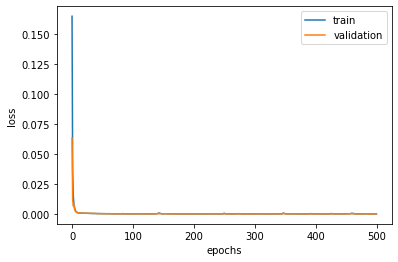

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

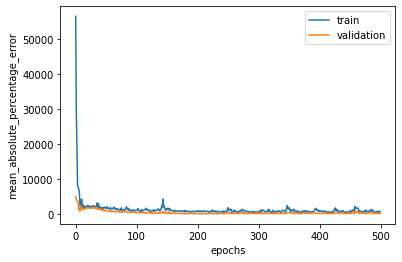

In [21]:
plt.plot(history.history['mean_absolute_percentage_error'], label='train')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('mean_absolute_percentage_error')
plt.legend()
plt.show()

In [77]:
sample = 2

y_pred = model_e2d2.predict(
    [x_train[sample].reshape(1, max_x_len, 5)], #, np.arange(max_x_len).reshape(1, max_x_len)]
    ).reshape(max_x_len, 2)

y_pred.shape, x_train[sample].shape

((77, 2), (77, 5))

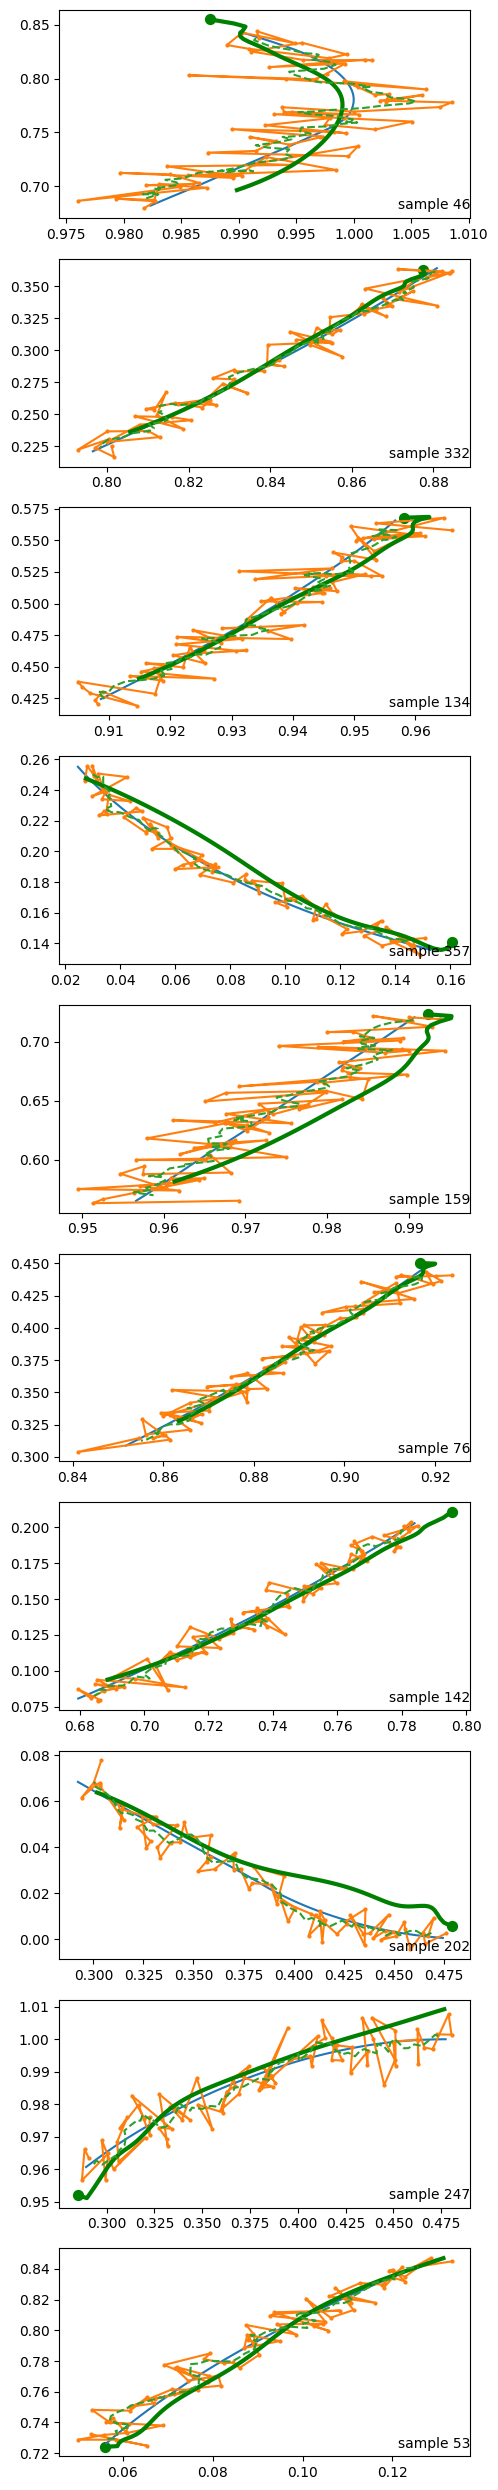

In [102]:
plt.figure(figsize=(5, 25))

for i, sample in enumerate(np.random.randint(0, 500, 10)):

    y_pred = model_e2d2.predict(
        [x_train[sample].reshape(1, max_x_len, 5)],
    ).reshape(max_x_len, 2)

    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_train[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_train[sample][:, 1], kernel, mode='valid')

    plt.subplot(10, 1, i+1)
    plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
    plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], '-o', label='noisy sample', ms=2)
    plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
    plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    plt.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')


    plt.title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.tight_layout()
plt.show()

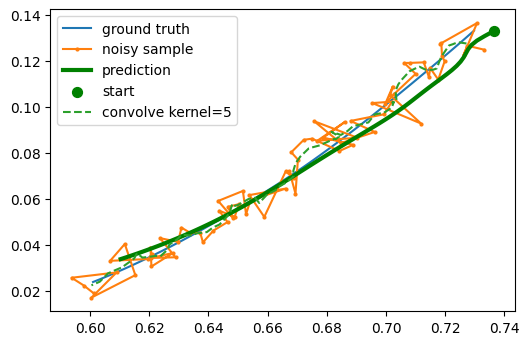

In [89]:

kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
lat_noisy_convolved = np.convolve(x_train[sample][:, 0], kernel, mode='valid')
lon_noisy_convolved = np.convolve(x_train[sample][:, 1], kernel, mode='valid')


plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], '-o', label='noisy sample', ms=2)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
plt.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

plt.legend()
plt.show()